In [324]:
import os
import time
import sys
sys.path.insert(0,'..')
from copy import deepcopy
import pickle
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
# sns.set_style("whitegrid")
from matplotlib import rc
rc('text', usetex=True)

import torch
import torch.nn as nn
from torch.autograd import Variable

%load_ext autoreload
%autoreload 2



from plot import smooth_plot,plot_curve,parse_loss_traj
from src.data import load_mnist
from src.utils import load_model_net,process_config
from src.models.mnist import resfnn as fnn_mnist
from src.trainer import eval_accuracy

traj_gd = parse_loss_traj('../experiments/fashionmnist_gd_batchsize_1200/data.pkl')
traj_sgd_z = parse_loss_traj('../experiments/fashionmnist_gd2sgd_batchsize_1_lr_1e-3_restart_3000_zoomin/loss.pkl')


def train_one_epoch(net,ct,optimizer,imgs,labels,
                    iter_start=3000,display=False,max_iters=-1,cool=False):
    traj = []
    if max_iters < 0:
        max_iters = len(labels)
    net0 = deepcopy(net)
    for idx in range(max_iters):
        X = Variable(imgs[idx:idx+1].cuda())
        y = Variable(labels[idx:idx+1].cuda())

        if cool:
            net.load_state_dict(net0.state_dict())
        optimizer.zero_grad()
        logit = net(X)
        E = ct(logit,y)
        E.backward()

        trL,trA,trC = eval_accuracy(net,trDL)
        teL,teA,teC = eval_accuracy(net,teDL)

        if display:
            print('%d, %d | \t %.2e  %.2f | \t %.2e  %.2f'%(
                idx, y.data[0], trL,trA,teL,teA
            ))
        traj.append((iter_start+idx,trL,trA,teL,teA,E.data[0]))
        optimizer.step()

    traj = list(zip(*traj))
    return traj

def comp_wait_time(train_loss,threshold=1):
    s = np.asarray(train_loss)
    n = len(s)
    for i in range(n-1):
        if s[i] < 30:
            return i
    return n

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data and network 

In [266]:
args = process_config('../configs/sgd_mnist.json')
trDL,teDL = load_mnist(
                    root = '../data/fashionmnist',
                    fashion=True,
                    batch_size = 1200,
                    nsamples = args.num_clean_samples,
                    num_wrong = args.num_wrong_samples,
                    stop = True
                )
net0 = fnn_mnist(depth=5).cuda()
iter_start = 14990
net0.load_state_dict(torch.load(
            os.path.join('../experiments/fashionmnist_gd_batchsize_1200/checkpoint/batchsize_1200_start_0_now_%d_end_15000.ckpt'%(iter_start))
))

ct = torch.nn.CrossEntropyLoss()


# test
trL,trA,trC = eval_accuracy(net0,trDL)
teL,teA,teC = eval_accuracy(net0,teDL)
print('Training: loss %.2e\t acc: %.2f\t conf: %.2f'%(trL,trA,trC))
print('Test:     loss %.2e\t acc: %.2f\t conf: %.2f'%(teL,teA,teC))

Training: loss 4.55e-05	 acc: 100.00	 conf: 100.00
Test:     loss 4.03e+00	 acc: 66.22	 conf: 94.17


# Train One Epoch

In [321]:
net = deepcopy(net0)

epsilon = 1e-2
for p in net.parameters():
    tmp = p.data.clone()
    p.data += tmp.normal_(0,epsilon)

# test
trL,trA,trC = eval_accuracy(net,trDL)
teL,teA,teC = eval_accuracy(net,teDL)
print('Training: loss %.2e\t acc: %.2f\t conf: %.2f'%(trL,trA,trC))
print('Test:     loss %.2e\t acc: %.2f\t conf: %.2f'%(teL,teA,teC))

optimizer = torch.optim.SGD(net.parameters(),
                        lr = 0.01
                    )


traj=train_one_epoch(net,ct,optimizer,trDL.X,trDL.y,iter_start=iter_start)


Training: loss 4.32e-02	 acc: 98.50	 conf: 99.22
Test:     loss 4.32e+00	 acc: 66.14	 conf: 94.40


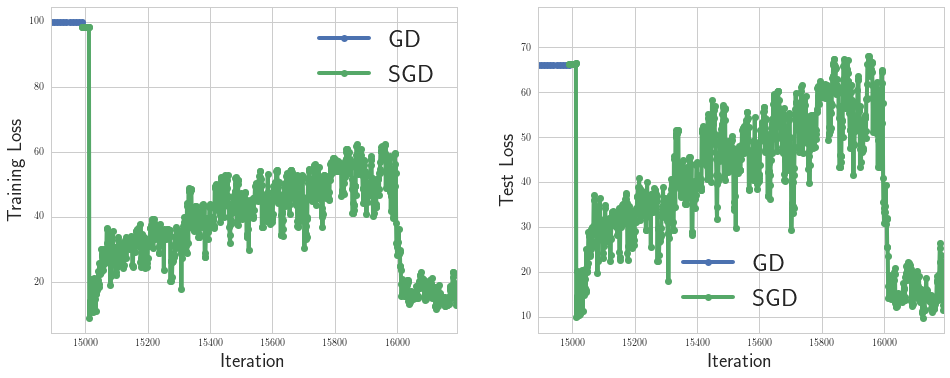

In [323]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1);
plot_curve(curve_list=[(traj_gd[0],traj_gd[2]),
            (traj[0],traj[2])], 
           labels=['GD','SGD'],
           xlabel=r'Iteration',
           ylabel=r'Training Loss',
           xlim=[iter_start-100,iter_start+1200],
#            ylim=[0,0.22],
           marker='o'
        )


plt.subplot(1,2,2); 
plot_curve(curve_list=[(traj_gd[0],traj_gd[4]),
            (traj[0],traj[4])], 
           labels=['GD','SGD'],
           xlabel=r'Iteration',
           ylabel=r'Test Loss',
           xlim=[iter_start-100,iter_start+1200],
           marker='o'
        )
plt.savefig('fashionmnist_perturb_gauss1e-2_escape.pdf',bbox_inches='tight')

## Show Loss of Each Sample

In [170]:
net = deepcopy(net0)
loss_list = []
imgs,labels = trDL.X,trDL.y
for idx in range(trDL.nsamples):
    X = Variable(imgs[idx:idx+1].cuda())
    y = Variable(labels[idx:idx+1].cuda())

    logit = net(X)
    E = ct(logit,y)
    loss_list.append(E.data[0])

(0, 0.04)

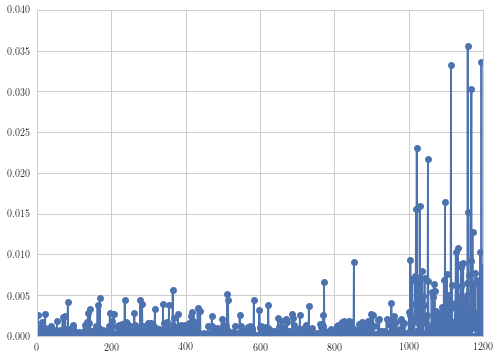

In [171]:
plt.figure(figsize=(8,6))
plt.plot(loss_list,'-o')
plt.xlim([0,1200])
plt.ylim([0,0.04])

### Sensitivity to gradient of per sample

In [172]:
net = deepcopy(net0)
optimizer = torch.optim.SGD(net.parameters(),
                        lr = 0.01
                    )

traj=train_one_epoch(net,ct,optimizer,trDL.X,trDL.y,cool=True)

/opt/software/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


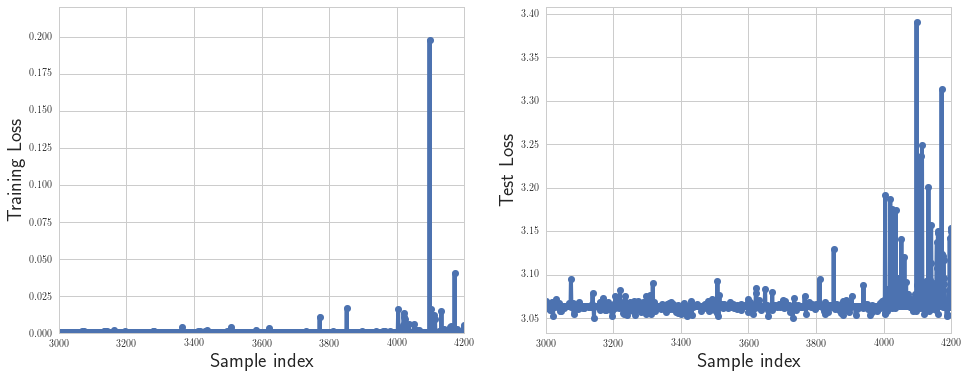

In [178]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1);
plot_curve(curve_list=[(traj[0],traj[1])], 
           labels=[''],
           xlabel=r'Sample index',
           ylabel=r'Training Loss',
           xlim=[3000,4200],
           ylim=[0,0.22],
           marker='o'
        )


plt.subplot(1,2,2); 
plot_curve(curve_list=[(traj[0],traj[3])], 
           labels=[''],
           xlabel=r'Sample index',
           ylabel=r'Test Loss',
           xlim=[3000,4200],
           marker='o'
        )

## Shuffle  Experiment

In [218]:
imgs,labels = trDL.X.clone(),trDL.y.clone()
# imgs[0:30] = imgs[1170:1200]
# labels[0:30] = labels[1170:1200]
rnd_idx = torch.randperm(len(labels))
imgs = imgs[rnd_idx]
labels = labels[rnd_idx]

In [219]:
net = deepcopy(net0)
optimizer = torch.optim.SGD(net.parameters(),
                        lr = 0.01
                    )

traj_new=train_one_epoch(net,ct,optimizer,imgs,labels,max_iters=1200)

66

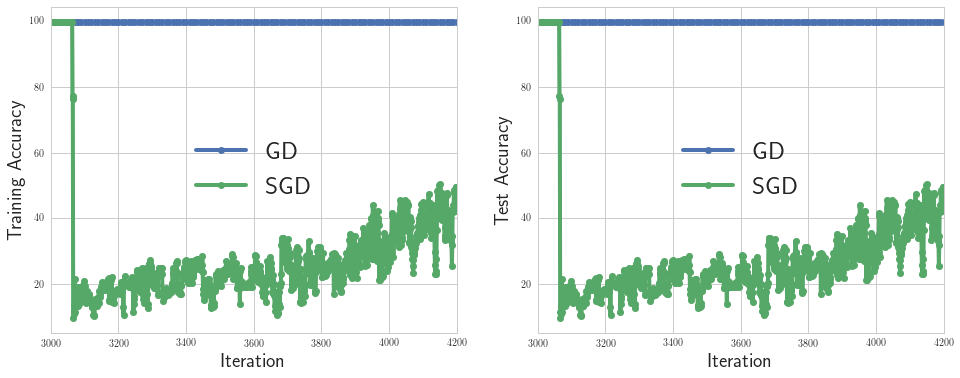

In [225]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1);
plot_curve(curve_list=[(traj_gd[0],traj_gd[2]),
            (traj_new[0],traj_new[2])], 
           labels=['GD','SGD'],
           xlabel=r'Iteration',
           ylabel=r'Training Accuracy',
           xlim=[3000,4200],
           marker='o'
        )


plt.subplot(1,2,2); 
plot_curve(curve_list=[(traj_gd[0],traj_gd[2]),
            (traj_new[0],traj_new[2])], 
           labels=['GD','SGD'],
           xlabel=r'Iteration',
           ylabel=r'Test Accuracy',
           xlim=[3000,4200],
           marker='o'
        )
comp_wait_time(traj_new[2])

In [275]:
with open('wait_time.pkl','rb') as f:
    data = pickle.load(f)

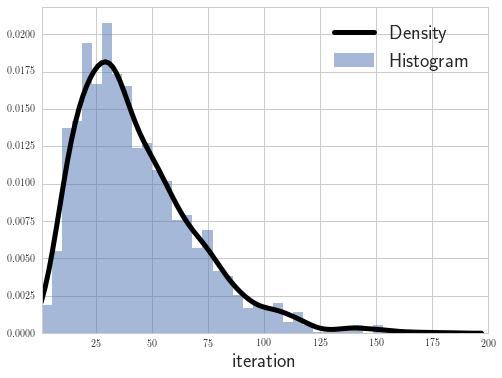

In [312]:
plt.figure(figsize=(8,6))
sns.distplot(data,bins=40,kde=True,
             hist_kws={"lw":3,"alpha":0.5,"label":"Histogram"},
             kde_kws={"color": "k", "lw": 5, "label": "Density"})
plt.xlim([1,200])
plt.xlabel('iteration',fontsize=20)
plt.legend(fontsize=20)
plt.savefig('figs/fashionmnist_start3000_wait_time_distribution.pdf',bbox_inches='tight')